# Particle simulation vs Langevin model

In [1]:
using ProgressMeter
using Revise
using JLD2

In [2]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist
using DifferentialEquations, Distributions

## Growing population

### Parameters

In [3]:
using Plots
# plotly()
gr()
# plotlyjs()
# pyplot()

Plots.GRBackend()

In [4]:
using LaTeXStrings

In [5]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
    arenaParams["E"] = arenaParams["speed"]^2/2
end

extendParams! (generic function with 1 method)

In [6]:
arenaParams = 
    Dict(
        "n0"=>100,
        "evolveTime"=>4500,
        "bounds"=>((0.,10.),(0.,10.)), 
        "radius"=>0.08, 
        "speed"=>0.02,
        "timeStep"=> 0.1
    )

growthParams =
    Dict(
        "ρ"=> 0.002,
        "k"=> 1000,
        "randGrowth"=> false,
        "waitTime"=> 500
    )

extendParams!(arenaParams)

display(arenaParams)
display(growthParams)

function fillDensity(arenaParams, growthParams)  
    xperiod = abs(arenaParams["bounds"][1][2] - arenaParams["bounds"][1][1])
    yperiod = abs(arenaParams["bounds"][2][2] - arenaParams["bounds"][2][1])
    n0 = arenaParams["n0"]
    nT = growthParams["k"]
    r = arenaParams["radius"]
    V = xperiod*yperiod
    fillDens0 = n0*π*r^2 / V
    fillDensT = nT*π*r^2 / V
    return fillDens0, fillDensT
end

volumeDens(n, r, V) = n*π*r^2/V

timeSteps = arenaParams["timeStep"]:arenaParams["timeStep"]:arenaParams["evolveTime"]

println("t0 density: ", fillDensity(arenaParams, growthParams)[1])
println("t0 density: ", fillDensity(arenaParams, growthParams)[2])

Dict{String,Any} with 9 entries:
  "volume"     => 100.0
  "evolveTime" => 4500
  "speed"      => 0.02
  "radius"     => 0.08
  "timeStep"   => 0.1
  "E"          => 0.0002
  "bounds"     => ((0.0, 10.0), (0.0, 10.0))
  "bperiod"    => [10.0, 10.0]
  "n0"         => 100

Dict{String,Real} with 4 entries:
  "waitTime"   => 500
  "k"          => 1000
  "ρ"          => 0.002
  "randGrowth" => false

t0 density: 0.02010619298297468
t0 density: 0.20106192982974677


### Logistic Growth

The number of cells in the system increases according to the logistic growth function:
\begin{equation}
n(t) = \frac{k}{ 1 + \frac{k-n_0}{n_0}e^{-\rho t}}
\end{equation}


### Mean Free Path and Friction

In [7]:
nCells_t = Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            growthParams["ρ"], growthParams["k"], arenaParams["n0"]);

mfpTheory_t = (x -> Theorist.meanFreePath(x, 4*arenaParams["radius"])).(nCells_t);
frictionTheory_t = ( l -> Theorist.friction(l, arenaParams["E"]) ).(mfpTheory_t);

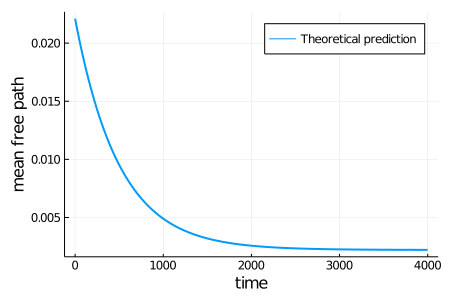

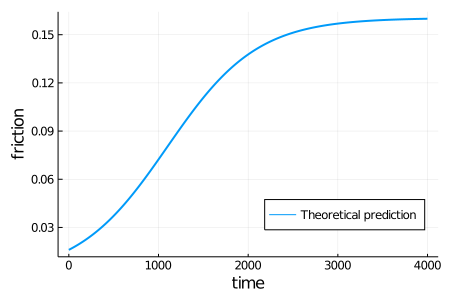

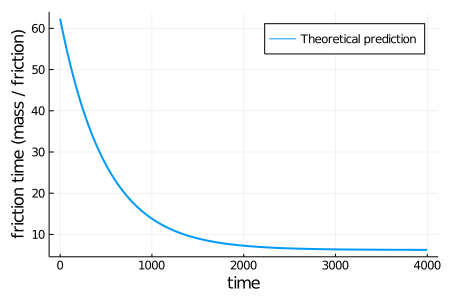

In [8]:
f2 = plot(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), mfpTheory_t,
        label="Theoretical prediction",
        linewidth=2,
        legend=:topright,
        size=(450,300))
xlabel!("time")
ylabel!("mean free path")
display(f2)

savefig(f2, "../Figures/rho"*string(growthParams["ρ"])*"mfp_time.pdf")

f3 = plot(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            arenaParams["speed"]*frictionTheory_t,
        label="Theoretical prediction",
        linewidth=2,
        legend=:bottomright,
        size=(450,300))
xlabel!("time")
ylabel!("friction")
display(f3)

savefig(f3, "../Figures/rho"*string(growthParams["ρ"])*"friction_time.pdf")

f4 = plot(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1),
            1 ./ (arenaParams["speed"]*frictionTheory_t),
        label="Theoretical prediction",
        linewidth=2,
#         legend=:bottomright,
        size=(450,300))
xlabel!("time")
ylabel!("friction time (mass / friction)")
display(f4)

savefig(f4, "../Figures/rho"*string(growthParams["ρ"])*"frictionTime_time.pdf")

Run Langevin simulations:

In [9]:
@time langevinEnsemble = Theorist.runLangevinSims(5000, arenaParams, growthParams);

Energy: 0.0002
208.012856 seconds (5.35 G allocations: 90.653 GiB, 12.19% gc time)


Run a particle simulation:

In [10]:
@time arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID, times_t = 
        BParts.randArenaEvolve(
            arenaParams["n0"], 
            arenaParams["evolveTime"],
            arenaParams["timeStep"],
            arenaParams,
            growthParams,
            verbose=true);

Building arena...
2 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02000000000000001


Progress:  60%|████████████████████████▊                |  ETA: 0:01:04

anomalous collision time 0.5427278329801699 found in time step0.1
anomalous collision time 5.735924508479325 found in time step0.1
anomalous collision time 8.830279961634442 found in time step0.1
anomalous collision time 6.120450030875821 found in time step0.1
anomalous collision time 2.36495562657887 found in time step0.1
anomalous collision time 1.8584883190003083 found in time step0.1
anomalous collision time 6.120450030875818 found in time step0.1
anomalous collision time 1.9207899262599217 found in time step0.1
anomalous collision time 6.655777301133299 found in time step0.1
anomalous collision time 16.770912547125842 found in time step0.1
anomalous collision time 3.9954488093731952 found in time step0.1
anomalous collision time 7.363754825046671 found in time step0.1
anomalous collision time 3.3367993557038025 found in time step0.1
anomalous collision time 24.211883350480136 found in time step0.1
anomalous collision time 2.7154116842296805 found in time step0.1
anomalous collisio

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:35

anomalous collision time 1.128096553081118 found in time step0.1
anomalous collision time 3.019411425405763 found in time step0.1
anomalous collision time 6.471389352778513 found in time step0.1
anomalous collision time 1.225572463523565 found in time step0.1
anomalous collision time 2.226218016200555 found in time step0.1
anomalous collision time 5.275477627135337 found in time step0.1
anomalous collision time 2.6966092953725784 found in time step0.1
anomalous collision time 3.24163932387196 found in time step0.1
anomalous collision time 0.6057582451159944 found in time step0.1
anomalous collision time 1.6324036232275334 found in time step0.1
anomalous collision time 3.5011396727403623 found in time step0.1
anomalous collision time 19.292176064126284 found in time step0.1
anomalous collision time 6.979037586392062 found in time step0.1
anomalous collision time 0.6192696781699222 found in time step0.1


BoundsError: BoundsError: attempt to access 0-element Array{Tuple{Float64,Array{Int64,1}},1} at index [1]

In [11]:
comVel = BParts.comVel(arena.cellsList)
Eav = BParts.avParticleEnergy(arena.cellsList)

println(comVel)
println(Eav)
println(length(arena.cellsList))

UndefVarError: UndefVarError: arena not defined

In [12]:
# msdPart0_t = BParts.meanSquaredDisplacement(pos_t_dim_id, msdTimes)

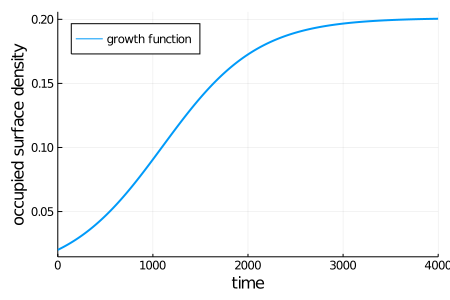

In [13]:
f1 = plot(0:(arenaParams["evolveTime"]-1-growthParams["waitTime"]), 
        volumeDens.(
            Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            growthParams["ρ"], growthParams["k"], arenaParams["n0"]),
            arenaParams["radius"],
            arenaParams["volume"]
        ),
        label="growth function",
        linewidth=2,
        size=(450,300),
        legend=:topleft)
# plot!(times_t .- growthParams["waitTime"], 
#     volumeDens.(
#         BParts.nCellsTime(cells_T_ID)[1:end],     
#         arenaParams["radius"],
#         arenaParams["volume"]
#     ),
#     label="particle simulation",
#     linewidth=2,
#     linestyle=:dash)
xlabel!("time")
ylabel!("occupied surface density")
xlims!(0,arenaParams["evolveTime"]-growthParams["waitTime"])
display(f1)

# savefig(f1, "../Figures/rho"*string(growthParams["ρ"])*"surfaceDensity_time.pdf")

Ensemble of particle simulations:

In [14]:
nSims = 50

pos_Sim = Array{Array{Union{Float64, Missing},3}}(undef, nSims)
@showprogress for i in 1:nSims
    succes = false
    while !succes 
        # try/catch construction in case boundserror occurs
        try
            @time _, posSim_t_dim_id, __, ___ = 
                BParts.randArenaEvolve(
                        arenaParams["n0"],
                        arenaParams["evolveTime"], 
                        arenaParams["timeStep"],
                        arenaParams,
                        growthParams,
                        progress=false,
                        verbose=true);
            pos_Sim[i] = posSim_t_dim_id
#             println("sim: ", i)
        catch e
#             println("fail")
            continue
        end
        succes = true
    end
end

Building arena...
2 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
244.805748 seconds (405.13 M allocations: 16.923 GiB, 3.61% gc time)


Progress:   2%|▉                                        |  ETA: 3:20:09

Building arena...
1 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
244.048022 seconds (405.11 M allocations: 16.925 GiB, 4.53% gc time)


Progress:   4%|█▋                                       |  ETA: 3:15:45

Building arena...
2 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
229.603224 seconds (404.54 M allocations: 16.896 GiB, 4.33% gc time)


Progress:   6%|██▌                                      |  ETA: 3:07:46

Building arena...
6 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 2.3577541489417784 found in time step0.1
anomalous collision time 2.613808880258611 found in time step0.1
anomalous collision time 2.385196678194795 found in time step0.1
anomalous collision time 7.295360520419676 found in time step0.1
anomalous collision time 3.5631226428366753 found in time step0.1
anomalous collision time 0.5544373294511658 found in time step0.1
anomalous collision time 7.631751463479172 found in time step0.1
anomalous collision time 6.710065455193629 found in time step0.1
anomalous collision time 11.019779099243655 found in time step0.1
anomalous collision time 10.482127112666667 found in time step0.1
anomalous collision time 3.4621743733072248 found in time step0.1
anomalous collision time 5.655071367833217 found in time step0.1
anomalous collision time 7.562267377382752 found in time ste

Progress:   8%|███▎                                     |  ETA: 3:01:42

228.792182 seconds (404.83 M allocations: 16.914 GiB, 3.87% gc time)
Building arena...
3 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
228.115295 seconds (404.70 M allocations: 16.910 GiB, 3.72% gc time)


Progress:  10%|████▏                                    |  ETA: 2:56:26

Building arena...
3 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
229.335671 seconds (405.30 M allocations: 16.928 GiB, 3.81% gc time)


Progress:  12%|████▉                                    |  ETA: 2:51:50

Building arena...
1 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
231.115422

Progress:  14%|█████▊                                   |  ETA: 2:47:36

 seconds (405.33 M allocations: 16.931 GiB, 4.50% gc time)
Building arena...
2 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
228.368215 seconds (404.84 M allocations: 16.913 GiB, 3.91% gc time)


Progress:  16%|██████▌                                  |  ETA: 2:43:14

Building arena...
1 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
227.190858

Progress:  18%|███████▍                                 |  ETA: 2:38:54

 seconds (404.26 M allocations: 16.887 GiB, 3.74% gc time)
Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 0.13091451158464373 found in time step0.1
anomalous collision time 9.7001204359106 found in time step0.1
anomalous collision time 9.714679496975144 found in time step0.1
anomalous collision time 0.18674909432566475 found in time step0.1
anomalous collision time 9.354984273391432 found in time step0.1
anomalous collision time 9.354984273391453 found in time step0.1
anomalous collision time 9.35498427339156 found in time step0.1
anomalous collision time 16.125277707896654 found in time step0.1
anomalous collision time 5.842289532633617 found in time step0.1
anomalous collision time 3.7829079837573976 found in time step0.1
anomalous collision time 30.251038029108283 found in time step0.1
anomalous collision time 30.34103653591297 found in time step0.1
ano

Progress:  20%|████████▎                                |  ETA: 2:48:39

Building arena...
3 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993
227.118264 seconds (403.98 M allocations: 16.878 GiB, 3.80% gc time)


Progress:  22%|█████████                                |  ETA: 2:42:55

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 0.2854611168557092 found in time step0.1
anomalous collision time 6.77027304391151 found in time step0.1
anomalous collision time 0.45308719764640004 found in time step0.1
anomalous collision time 3.0028038363153398 found in time step0.1
anomalous collision time 1.693773417232353 found in time step0.1
anomalous collision time 18.60736682145227 found in time step0.1
anomalous collision time 4.868766924938371 found in time step0.1
anomalous collision time 31.302945778159447 found in time step0.1
anomalous collision time 3.004788931385907 found in time step0.1
anomalous collision time 16.564877060896396 found in time step0.1
anomalous collision time 40.30840458626045 found in time step0.1
anomalous collision time 5.88696261495151 found in time step0.1
anomalous collision time 10.184822726488203 found in time step0.1
anomalous co

Progress:  24%|█████████▉                               |  ETA: 2:37:33

 seconds (405.06 M allocations: 16.922 GiB, 3.85% gc time)
Building arena...
1 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
226.732642 seconds (404.32 M allocations: 16.888 GiB, 3.69% gc time)


Progress:  26%|██████████▋                              |  ETA: 2:32:21

Building arena...
2 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
226.818140 seconds (404.24 M allocations: 16.888 GiB, 3.69% gc time)


Progress:  28%|███████████▌                             |  ETA: 2:27:23

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
227.415421 seconds (404.84 M allocations: 16.911 GiB, 3.87% gc time)


Progress:  30%|████████████▎                            |  ETA: 2:22:35

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02000000000000001
227.220594

Progress:  32%|█████████████▏                           |  ETA: 2:17:54

 seconds (405.24 M allocations: 16.929 GiB, 3.76% gc time)
Building arena...
5 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993
227.059504

Progress:  34%|██████████████                           |  ETA: 2:13:19

 seconds (404.83 M allocations: 16.910 GiB, 3.69% gc time)
Building arena...
5 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
227.060582

Progress:  36%|██████████████▊                          |  ETA: 2:08:50

 seconds (404.86 M allocations: 16.916 GiB, 3.67% gc time)
Building arena...
3 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
236.147145 seconds (405.46 M allocations: 16.937 GiB, 3.60% gc time)


Progress:  38%|███████████████▋                         |  ETA: 2:04:40

Building arena...
7 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 0.2044090734773352 found in time step0.1
236.079455 seconds (405.09 M allocations: 16.925 GiB, 6.05% gc time)


Progress:  40%|████████████████▍                        |  ETA: 2:00:31

Building arena...
3 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 4.339286384164426 found in time step0.1
anomalous collision time 11.996057748672555 found in time step0.1
anomalous collision time 2.2552352386333823 found in time step0.1
anomalous collision time 5.975963856733673 found in time step0.1
anomalous collision time 2.8394361524264724 found in time step0.1
anomalous collision time 4.82879521463497 found in time step0.1
anomalous collision time 16.440284016632173 found in time step0.1
anomalous collision time 4.271588519971791 found in time step0.1
anomalous collision time 15.145704120905377 found in time step0.1
anomalous collision time 23.333610306268305 found in time step0.1
anomalous collision time 16.50371299264098 found in time step0.1
anomalous collision time 6.233647153240599 found in time step0.1
Building arena...
2 overlaps found.
Removing center of mass d

Progress:  42%|█████████████████▎                       |  ETA: 1:59:39

Building arena...
6 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 0.5022732377068377 found in time step0.1
anomalous collision time 12.353503098324554 found in time step0.1
anomalous collision time 2.612612147852364 found in time step0.1
anomalous collision time 12.918611689428989 found in time step0.1
anomalous collision time 91.02863382711864 found in time step0.1
anomalous collision time 3.111792960459931 found in time step0.1
anomalous collision time 3.111792960459931 found in time step0.1
anomalous collision time 126.0126974676313 found in time step0.1
anomalous collision time 3.111792960459931 found in time step0.1
anomalous collision time 13.178603820932906 found in time step0.1
anomalous collision time 7.560474777054305 found in time step0.1
anomalous collision time 23.305683435453584 found in time step0.1
anomalous collision time 13.178603820932906 found in time ste

Progress:  44%|██████████████████                       |  ETA: 1:55:10

230.642077 seconds (404.70 M allocations: 16.909 GiB, 3.91% gc time)
Building arena...
6 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
229.428200 seconds (404.62 M allocations: 16.903 GiB, 3.71% gc time)


Progress:  46%|██████████████████▉                      |  ETA: 1:50:43

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
230.226641 seconds (405.07 M allocations: 16.922 GiB, 3.73% gc time)


Progress:  48%|███████████████████▋                     |  ETA: 1:46:20

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999987
anomalous collision time 0.12072664992003114 found in time step0.1
anomalous collision time 17.720510196228012 found in time step0.1
anomalous collision time 7.086723718331248 found in time step0.1
anomalous collision time 6.236143797729792 found in time step0.1
anomalous collision time 4.847905235039859 found in time step0.1
anomalous collision time 41.697375808349385 found in time step0.1
anomalous collision time 4.408796851410372 found in time step0.1
anomalous collision time 0.7719325927473644 found in time step0.1
anomalous collision time 1.389220419183587 found in time step0.1
anomalous collision time 68.23047059608047 found in time step0.1
anomalous collision time 8.031893514695664 found in time step0.1
anomalous collision time 4.376723858195663 found in time step0.1
anomalous collision time 68.23047059608025 found in time step

Progress:  50%|████████████████████▌                    |  ETA: 1:44:01

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
229.441422

Progress:  52%|█████████████████████▍                   |  ETA: 1:39:33

 seconds (405.07 M allocations: 16.922 GiB, 3.77% gc time)
Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 0.1513109014047968 found in time step0.1
anomalous collision time 55.09235972874442 found in time step0.1
anomalous collision time 9.193606879113897 found in time step0.1
anomalous collision time 15.145391557168178 found in time step0.1
anomalous collision time 14.619645848380253 found in time step0.1
anomalous collision time 2.761958790729875 found in time step0.1
anomalous collision time 15.362718637846971 found in time step0.1
anomalous collision time 8.925411967320713 found in time step0.1
anomalous collision time 10.881448038403782 found in time step0.1
anomalous collision time 2.571226883087882 found in time step0.1
anomalous collision time 10.8814480384038 found in time step0.1
anomalous collision time 0.2000854103457752 found in time step0.1
anomalous collisio

Progress:  54%|██████████████████████▏                  |  ETA: 1:37:45

 seconds (404.28 M allocations: 16.890 GiB, 3.25% gc time)
Building arena...
6 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999987
227.237601 seconds (404.80 M allocations: 16.911 GiB, 3.68% gc time)


Progress:  56%|███████████████████████                  |  ETA: 1:33:08

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 1.0341631621541334 found in time step0.1
anomalous collision time 9.191526350723437 found in time step0.1
anomalous collision time 9.547323120200579 found in time step0.1
anomalous collision time 9.202381126574405 found in time step0.1
anomalous collision time 5.989477791879967 found in time step0.1
anomalous collision time 8.711114682704933 found in time step0.1
anomalous collision time 6.5683494819168775 found in time step0.1
anomalous collision time 6.5683494819168775 found in time step0.1
anomalous collision time 7.681103035711503 found in time step0.1
anomalous collision time 14.576100402371795 found in time step0.1
anomalous collision time 2.5950338262804413 found in time step0.1
anomalous collision time 5.920969109221639 found in time step0.1
anomalous collision time 7.505947544847983 found in time step

Progress:  58%|███████████████████████▊                 |  ETA: 1:30:12

Building arena...
3 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 0.27592703310869043 found in time step0.1
anomalous collision time 16.59170754623835 found in time step0.1
anomalous collision time 1.8269283717287164 found in time step0.1
anomalous collision time 7.872216032934089 found in time step0.1
anomalous collision time 8.611690760028083 found in time step0.1
anomalous collision time 7.9874249814726195 found in time step0.1
anomalous collision time 0.11627458639495991 found in time step0.1
anomalous collision time 4.171532817976177 found in time step0.1
anomalous collision time 4.2031009792243506 found in time step0.1
anomalous collision time 0.7294262090718133 found in time step0.1
anomalous collision time 1.8850512952118719 found in time step0.1
anomalous collision time 3.6768093422358454 found in time step0.1
anomalous collision time 0.9529756580597708 found in tim

Progress:  60%|████████████████████████▋                |  ETA: 1:25:57

Building arena...
3 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 0.12294733154233582 found in time step0.1
anomalous collision time 0.11045643278859014 found in time step0.1
anomalous collision time 2.8743749807645673 found in time step0.1
anomalous collision time 1.6437523473536153 found in time step0.1
anomalous collision time 2.885113535248024 found in time step0.1
anomalous collision time 0.10322608288325888 found in time step0.1
anomalous collision time 7.312887987476394 found in time step0.1
anomalous collision time 1.9191952110088994 found in time step0.1
anomalous collision time 7.379983773555217 found in time step0.1
259.871653 seconds (405.04 M allocations: 16.917 GiB, 3.88% gc time)


Progress:  62%|█████████████████████████▍               |  ETA: 1:21:40

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 2.5498601012795095 found in time step0.1
anomalous collision time 2.6271105436958844 found in time step0.1
anomalous collision time 14.566541722509557 found in time step0.1
anomalous collision time 32.06734171386736 found in time step0.1
anomalous collision time 5.930836924150683 found in time step0.1
anomalous collision time 58.067260112883034 found in time step0.1
anomalous collision time 58.06726011288301 found in time step0.1
anomalous collision time 58.06726011288305 found in time step0.1
anomalous collision time 2.0874365113350817 found in time step0.1
anomalous collision time 0.4111485940957314 found in time step0.1
anomalous collision time 58.06726011288304 found in time step0.1
anomalous collision time 11.464333648814497 found in time step0.1
anomalous collision time 6.955896454418212 found in time step0.1
anomalous 

Progress:  64%|██████████████████████████▎              |  ETA: 1:17:24

Building arena...
2 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 0.87756486170865 found in time step0.1
anomalous collision time 7.021128972197822 found in time step0.1
anomalous collision time 0.9374730184171208 found in time step0.1
anomalous collision time 2.8875452340012973 found in time step0.1
anomalous collision time 2.4990395397402474 found in time step0.1
anomalous collision time 5.292213367267366 found in time step0.1
anomalous collision time 1.0948335395916473 found in time step0.1
259.398847 seconds (404.87 M allocations: 16.911 GiB, 3.89% gc time)


Progress:  66%|███████████████████████████              |  ETA: 1:13:07

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000014
anomalous collision time 4.65204141127219 found in time step0.1
anomalous collision time 4.70335539727619 found in time step0.1
anomalous collision time 11.852297957354653 found in time step0.1
anomalous collision time 12.049595162040562 found in time step0.1
anomalous collision time 1.0421002626759543 found in time step0.1
anomalous collision time 1.2595449113861032 found in time step0.1
anomalous collision time 12.04959516204058 found in time step0.1
anomalous collision time 0.6375055634308696 found in time step0.1
260.006548 seconds (405.01 M allocations: 16.918 GiB, 3.82% gc time)


Progress:  68%|███████████████████████████▉             |  ETA: 1:08:50

Building arena...
5 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
255.750566 seconds (404.48 M allocations: 16.897 GiB, 3.90% gc time)


Progress:  70%|████████████████████████████▊            |  ETA: 1:04:31

Building arena...
3 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993
247.672939

Progress:  72%|█████████████████████████████▌           |  ETA: 1:00:09

 seconds (404.52 M allocations: 16.896 GiB, 4.03% gc time)
Building arena...
6 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 1.7810256042137804 found in time step0.1
anomalous collision time 7.196240820998887 found in time step0.1
anomalous collision time 1.8562469023411254 found in time step0.1
anomalous collision time 6.202370194002701 found in time step0.1
anomalous collision time 10.49849789612615 found in time step0.1
anomalous collision time 1.6076236345787707 found in time step0.1
anomalous collision time 14.171729696907114 found in time step0.1
anomalous collision time 8.19401063062781 found in time step0.1
anomalous collision time 2.9634647163983976 found in time step0.1
anomalous collision time 0.11736329889507859 found in time step0.1
anomalous collision time 5.062489676709447 found in time step0.1
anomalous collision time 4.275450449742939 found in time step0.1
anomalous collisi

Progress:  74%|██████████████████████████████▍          |  ETA: 0:55:47

 seconds (404.90 M allocations: 16.917 GiB, 4.05% gc time)
Building arena...
6 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02000000000000001
anomalous collision time 0.12966974217674057 found in time step0.1
anomalous collision time 4.683024415825641 found in time step0.1
anomalous collision time 16.859035143987626 found in time step0.1
anomalous collision time 0.13533841027187915 found in time step0.1
anomalous collision time 4.2643264218493195 found in time step0.1
anomalous collision time 2.8857293184241306 found in time step0.1
anomalous collision time 6.744921924324884 found in time step0.1
anomalous collision time 3.5858736217860367 found in time step0.1
anomalous collision time 1.5203052321235921 found in time step0.1
anomalous collision time 4.841970536114915 found in time step0.1
anomalous collision time 12.544593923622918 found in time step0.1
anomalous collision time 16.910818186720206 found in time step0

Progress:  76%|███████████████████████████████▏         |  ETA: 0:51:25

Building arena...
6 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
244.747996 seconds (404.47 M allocations: 16.896 GiB, 3.84% gc time)


Progress:  78%|████████████████████████████████         |  ETA: 0:47:05

Building arena...
5 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
246.357839

Progress:  80%|████████████████████████████████▊        |  ETA: 0:42:45

 seconds (405.09 M allocations: 16.921 GiB, 4.41% gc time)
Building arena...
2 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
243.621032

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:38:26

 seconds (404.74 M allocations: 16.907 GiB, 3.61% gc time)
Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 6.154367243591043 found in time step0.1
anomalous collision time 5.3376409308711 found in time step0.1
anomalous collision time 9.0347004660869 found in time step0.1
anomalous collision time 6.119072710973048 found in time step0.1
anomalous collision time 9.034700466086887 found in time step0.1
anomalous collision time 7.44387328332369 found in time step0.1
anomalous collision time 10.581601618368952 found in time step0.1
anomalous collision time 9.034700466086903 found in time step0.1
anomalous collision time 8.905089351219669 found in time step0.1
anomalous collision time 5.601019041252116 found in time step0.1
anomalous collision time 10.798349617207476 found in time step0.1
anomalous collision time 3.4443857851570847 found in time step0.1
anomalous collision time 

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:34:35

 seconds (404.87 M allocations: 16.919 GiB, 3.17% gc time)
Building arena...
3 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
243.499220

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:30:13

 seconds (404.63 M allocations: 16.902 GiB, 3.62% gc time)
Building arena...
1 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993
244.276632 seconds (404.79 M allocations: 16.910 GiB, 3.67% gc time)


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:25:52

Building arena...
1 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
247.754659 seconds (404.62 M allocations: 16.905 GiB, 3.70% gc time)


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:21:32

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 0.399131921154686 found in time step0.1
250.399489 seconds (404.12 M allocations: 16.885 GiB, 6.09% gc time)


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:17:13

Building arena...
8 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 5.512895185541299 found in time step0.1
anomalous collision time 2.1603286453827693 found in time step0.1
anomalous collision time 3.2148612405178216 found in time step0.1
anomalous collision time 5.858032620858201 found in time step0.1
anomalous collision time 8.72048347099718 found in time step0.1
anomalous collision time 3.6754078378532147 found in time step0.1
anomalous collision time 3.6754078378532147 found in time step0.1
anomalous collision time 28.382962340248664 found in time step0.1
anomalous collision time 6.725188481484974 found in time step0.1
anomalous collision time 2.498059467834322 found in time step0.1
anomalous collision time 7.805751147951741 found in time step0.1
anomalous collision time 0.862081253557106 found in time step0.1
anomalous collision time 9.886229261983233 found in time step0

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:13:09

 seconds (404.38 M allocations: 16.892 GiB, 3.24% gc time)
Building arena...
6 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
245.747310 seconds (404.72 M allocations: 16.907 GiB, 3.77% gc time)


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:08:45

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 70.54934478105866 found in time step0.1
anomalous collision time 70.70290567289756 found in time step0.1
anomalous collision time 5.8335787439644236 found in time step0.1
anomalous collision time 1.753895522377354 found in time step0.1
anomalous collision time 5.2613796390832075 found in time step0.1
anomalous collision time 0.26439053930948414 found in time step0.1
236.336973 seconds (404.26 M allocations: 16.889 GiB, 5.84% gc time)


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:04:22

Building arena...
4 overlaps found.
Removing center of mass drift...
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
anomalous collision time 2.1702499547733964 found in time step0.1
anomalous collision time 8.985368288474463 found in time step0.1
anomalous collision time 6.667633699504938 found in time step0.1
anomalous collision time 35.459786103459805 found in time step0.1
anomalous collision time 11.169713856393992 found in time step0.1
anomalous collision time 10.253099891045867 found in time step0.1
anomalous collision time 2.1618763724587504 found in time step0.1
anomalous collision time 7.2778595130895996 found in time step0.1
anomalous collision time 2.1618763724587504 found in time step0.1
anomalous collision time 4.997738326355434 found in time step0.1
anomalous collision time 10.32385949431552 found in time step0.1
anomalous collision time 7.277859513089617 found in time step0.1
anomalous collision time 6.5390153262636215 found in time s

Progress: 100%|█████████████████████████████████████████| Time: 3:37:46


### Mean squared displacement

In [15]:
msdTimes = (growthParams["waitTime"]+1, arenaParams["evolveTime"])

(501, 4500)

In [16]:
@time msd_Sim_t = (p_t_dim_id -> BParts.meanSquaredDisplacement(p_t_dim_id, msdTimes)).(pos_Sim);
msdPart_t = Array{Float64, 1}(undef, msdTimes[2]-msdTimes[1]+1)
for i in 1:(msdTimes[2]-msdTimes[1]+1)
    msdPart_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim_t ])
end

 63.679318 seconds (401.60 M allocations: 44.908 GiB, 18.71% gc time)


In [17]:
length(msd_Sim_t[1])

4000

In [18]:
timesMSD_t, msdLan_t = 
    Theorist.msd(
        langevinEnsemble, 
        arenaParams,
        (growthParams["waitTime"]+1, arenaParams["evolveTime"])
    )

(501:1:4500, [0.0, 0.00040603426116609065, 0.0016244676051938576, 0.003649112840696509, 0.006465467141120248, 0.010084802359828322, 0.014488759355067543, 0.0196717225534533, 0.025638336340099478, 0.032370297850383825  …  80.07868480764971, 80.08709253335645, 80.09598412367238, 80.10376312540477, 80.1126158853267, 80.12300635098649, 80.13324332867222, 80.14387874127733, 80.15673975660874, 80.16941542953923])

In [19]:
saveName = "growingPop_multSims_rho"*string(growthParams["ρ"])*".jld2"

@save saveName arenaParams growthParams msd_Sim_t msdPart_t msdLan_t

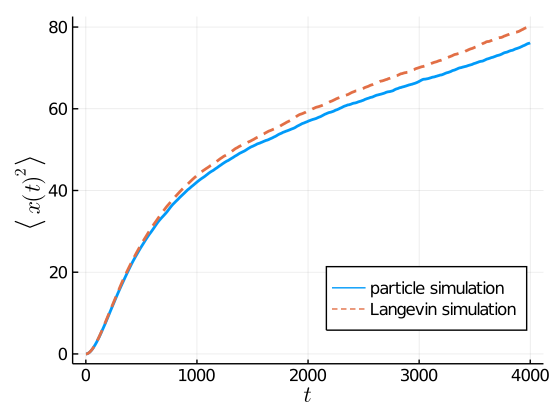

In [35]:
p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
    size=(400,300), 
    dpi=140)
plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
xlabel!(L"t")
ylabel!(L"\left\langle x(t)^2 \right\rangle")
# title!(latexstring("\\rho="*string(growthParams["ρ"])))
display(p2)

savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.png")
savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.pdf")

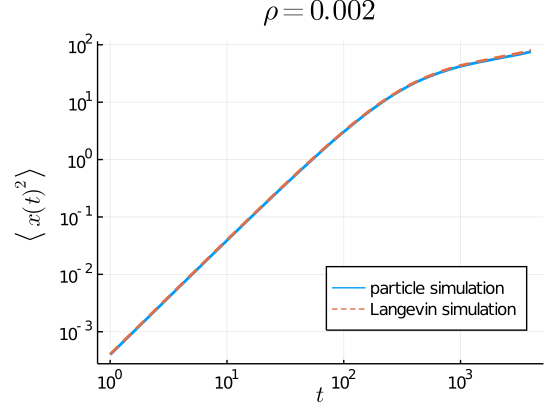

In [21]:
p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
    xaxis=:log10, yaxis=:log10,
    size=(400,300), 
    dpi=140)
plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
xlabel!(L"t")
ylabel!(L"\left\langle x(t)^2 \right\rangle")
title!(latexstring("\\rho="*string(growthParams["ρ"])))
display(p2)

# savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msdLoglog_time.png")
# savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msdLoglog_time.pdf")

## MSD linear regime

In [22]:
# msdTimes = (arenaParams["evolveTime"]-1000, arenaParams["evolveTime"])

In [23]:
# @time msd_Sim_t = (p_t_dim_id -> BParts.meanSquaredDisplacement(p_t_dim_id, msdTimes)).(pos_Sim);
# msdPart_t = Array{Float64, 1}(undef, msdTimes[2]-msdTimes[1]+1)
# for i in 1:(msdTimes[2]-msdTimes[1]+1)
#     msdPart_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim_t ])
# end

In [24]:
# length(msd_Sim_t[1])

In [25]:
# @time timesMSD_t, msdLan_t = 
#     Theorist.msd(
#         langevinEnsemble, 
#         arenaParams,
#         (arenaParams["evolveTime"]-1000, arenaParams["evolveTime"])
#     )
# # msdPar_t = BParts.meanSquaredDisplacement(pos_t_dim_id[1:msdTime,:,:], arenaParams["bperiod"]);

In [26]:
# p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
#     size=(400,300), 
#     dpi=140)
# plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
# xlabel!(L"t")
# ylabel!(L"\left\langle x(t)^2 \right\rangle")
# # title!(latexstring("\\rho="*string(growthParams["ρ"])))
# display(p2)


In [27]:
# msdSingles_Sim = []

# for sim in 1:nSims
#     msd_t = BParts.meanSquaredDisplacement(pos_Sim[sim], msdTimes)
#     push!(msdSingles_Sim, msd_t)
# end

In [28]:
# p3 = plot(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=3,
#     legend=:topleft,
#     size=(500,300),
#     dpi=140)
# # plot!(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation average", linestyle=:dashdot, linewidth=3)
# # plot!(1:msdTimes[2]-msdTimes[1], msdPart0_t[2:end])
# for s in 1:nSims
#     plot!(1:msdTimes[2]-msdTimes[1], msdSingles_Sim[s][2:end],
# #         label="particle simulation "*string(s),
#         label="")
# end
# xlabel!(L"t")
# ylabel!(L"\left\langle x(t)^2 \right\rangle")
# # title!(latexstring("\\rho="*string(growthParams["ρ"])))
# display(p3)

# # savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.png")
# savefig(p3, "../Figures/rho"*string(growthParams["ρ"])*"msdSingles_time.pdf")

## Position monitor

In [29]:
# pos_Sim[i] = posSim_t_dim_id
# cellID = 22

# p3 = plot(pos_Sim[4][:,1,1],pos_Sim[4][:,2,1], label="")
# for cellID in 2:100
#     plot!(pos_Sim[4][:,1,cellID],pos_Sim[4][:,2,cellID], label="")
# end

# display(p3)

In [30]:
# simNumber = 3

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")

In [31]:
# simNumber = 4

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")

In [32]:
# simNumber = 1

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")

In [33]:
# simNumber = 2

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")

In [34]:
# simNumber = 5

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")